# Blood Group Detection using Fingerprint

#### Import the required libraries

In [1]:
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import zipfile
import warnings
warnings.filterwarnings('ignore')

#### Download and unzip the dataset

In [2]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
 71% 41.0M/58.1M [00:00<00:00, 109MB/s]
100% 58.1M/58.1M [00:00<00:00, 137MB/s]


In [4]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

#### Preprocess the data

In [5]:
transform = Compose([Resize((64, 64)), ToTensor()])
dataset = ImageFolder('/content/dataset_blood_group', transform=transform)
print(dataset.classes)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


#### Splitting the dataset into train and test sets

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
val_size = 1000
test_size = 1000
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

#### Dataloaders

In [7]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)

#### Base class for model

In [8]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#### Model architecture

In [9]:
class FingerprintToBloodGroup(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, len(dataset.classes))
        )

    def forward(self, xb):
        return self.network(xb)

In [10]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

#### Validation function

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

#### Model training

In [24]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

            images, labels = batch
            out = model(images)
            acc = accuracy(out, labels)
            train_acc += acc.item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        result = evaluate(model, val_loader)
        val_loss = result['val_loss']
        val_acc = result['val_acc']

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    return history

In [26]:
@torch.no_grad()
def evaluate_with_predictions(model, val_loader):
    model.eval()
    predictions, targets = [], []
    for batch in val_loader:
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(targets)

In [27]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = FingerprintToBloodGroup()
model = to_device(model, device)

num_epochs = 20
lr = 0.001

history = fit(num_epochs, lr, model, train_dl, val_dl)

Epoch 1/20 - train_loss: 2.0696 - train_acc: 0.1680 - val_loss: 2.0269 - val_acc: 0.1683
Epoch 2/20 - train_loss: 1.9589 - train_acc: 0.2234 - val_loss: 1.7949 - val_acc: 0.3041
Epoch 3/20 - train_loss: 1.6758 - train_acc: 0.3530 - val_loss: 1.5082 - val_acc: 0.4045
Epoch 4/20 - train_loss: 1.4064 - train_acc: 0.4775 - val_loss: 1.2579 - val_acc: 0.5250
Epoch 5/20 - train_loss: 0.9483 - train_acc: 0.6741 - val_loss: 0.9041 - val_acc: 0.6731
Epoch 6/20 - train_loss: 0.7205 - train_acc: 0.7534 - val_loss: 0.7191 - val_acc: 0.7355
Epoch 7/20 - train_loss: 0.6263 - train_acc: 0.7783 - val_loss: 0.5488 - val_acc: 0.8016
Epoch 8/20 - train_loss: 0.4562 - train_acc: 0.8457 - val_loss: 0.5260 - val_acc: 0.8239
Epoch 9/20 - train_loss: 0.4392 - train_acc: 0.8535 - val_loss: 0.4898 - val_acc: 0.8308
Epoch 10/20 - train_loss: 0.4195 - train_acc: 0.8545 - val_loss: 0.5199 - val_acc: 0.8330
Epoch 11/20 - train_loss: 0.3626 - train_acc: 0.8792 - val_loss: 0.4141 - val_acc: 0.8480
Epoch 12/20 - train

#### Saving the model

In [32]:
torch.save(model.state_dict(), 'model.pth')

#### Model evaluation

In [28]:
predictions, targets = evaluate_with_predictions(model, val_dl)
print("Classification Report:\n")
print(classification_report(targets, predictions, target_names=dataset.classes))

Classification Report:

              precision    recall  f1-score   support

          A+       0.84      0.95      0.89       104
          A-       0.87      0.86      0.87       168
         AB+       0.96      0.75      0.84       131
         AB-       0.81      0.83      0.82       113
          B+       0.83      0.89      0.86       101
          B-       0.86      0.96      0.91       132
          O+       0.81      0.89      0.85       145
          O-       0.90      0.69      0.78       106

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



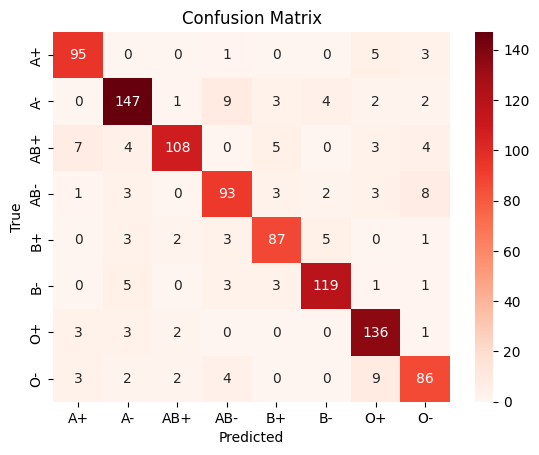

In [18]:
cm = confusion_matrix(targets, predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, dataset.classes)

#### Visualizing accuracy and loss over epochs

In [29]:
acc = history['train_acc']
val_acc = history['val_acc']
loss = history['train_loss']
val_loss = history['val_loss']
epochs_range = range(len(acc))

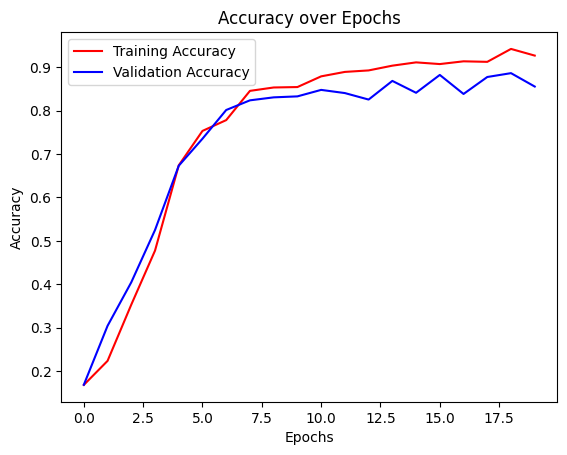

In [30]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

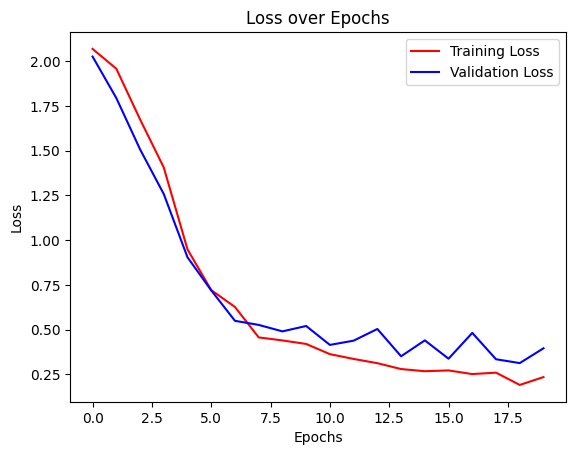

In [31]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [38]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    img_tensor = img_tensor.to(next(model.parameters()).device)

    model.eval()

    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class_index = torch.max(output, 1)

    predicted_class = class_names[predicted_class_index.item()]
    confidence_score = torch.nn.functional.softmax(output, dim=1)[0][predicted_class_index.item()] * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

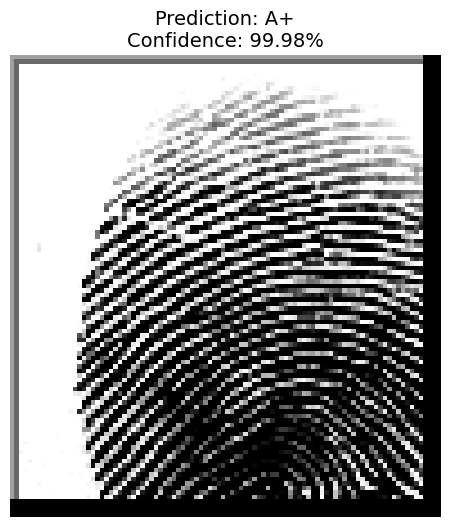

In [39]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

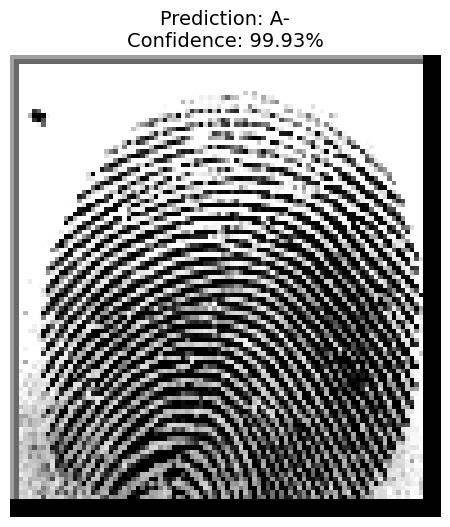

In [40]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

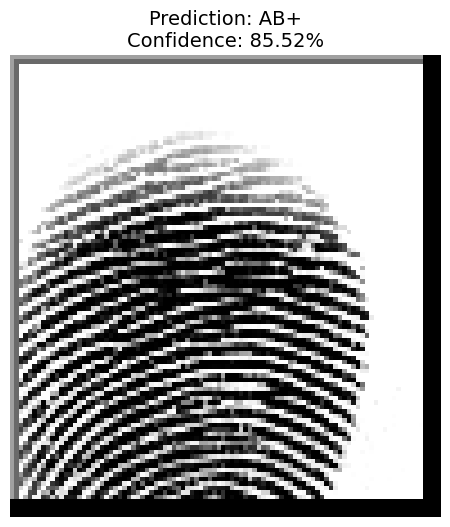

In [41]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

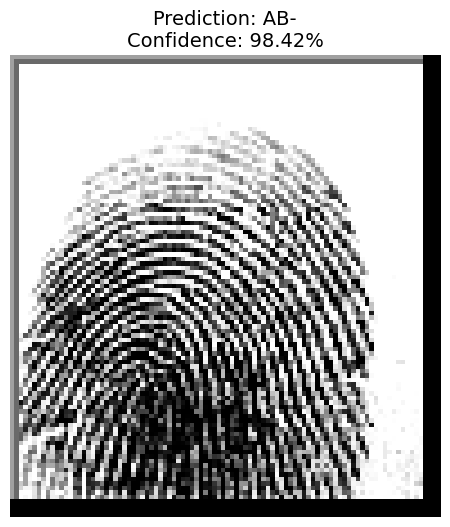

In [42]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1052.BMP'
predict_blood_group(image_path, model, class_names)

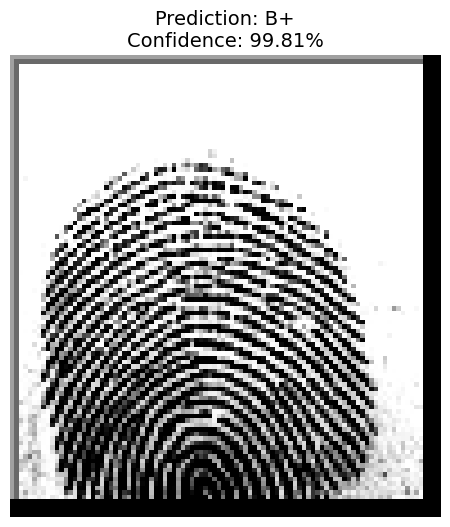

In [43]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

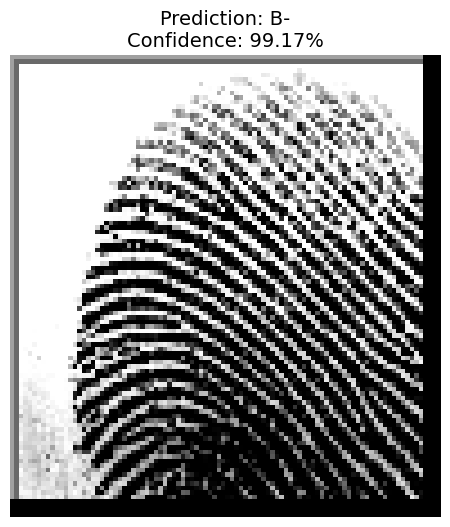

In [44]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

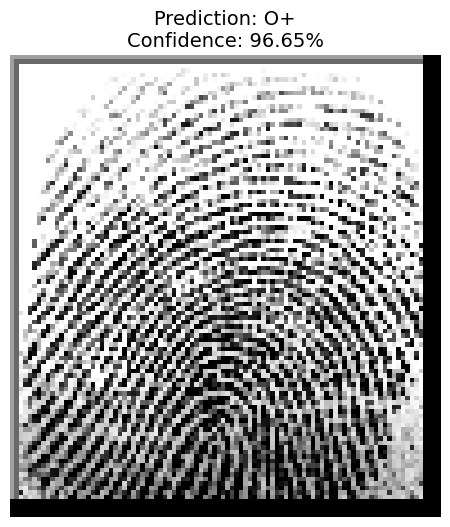

In [45]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

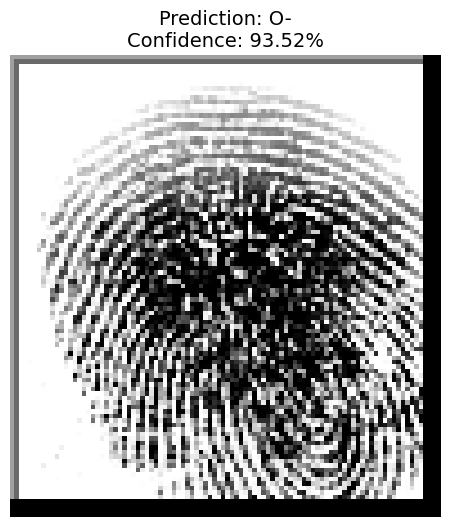

In [46]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1177.BMP'
predict_blood_group(image_path, model, class_names)